# NQ-0 Filtering

in order to increase the efficiency of our system we need to filter nq-0 which might prevent a large number of our users from getting performant for a particular partner. this is a way of avoiding systemic blocks on users for various reasons. 


each partner has its own status codes and various mechanisms that would prevent a user from being able to take surveys with them. the goal of this is to find instances of users who underperform with 

In [1]:
# import libs
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import pymoo

from utils import generate_data

## 1. Data Analysis 

goals:
- understand distribution of nq rates for users

In [ ]:
df = pd.read_csv('./data/partner_users_dataset.csv')

[]

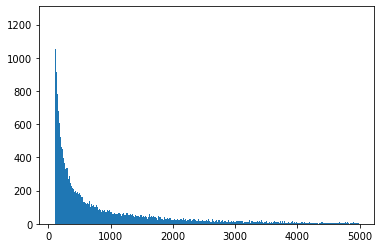

In [38]:
plt.hist(df['user_id'].value_counts().values, bins=[i*10 for i in range(10, 5*100)])
plt.plot()

In [39]:
#df_users = df.groupby(['user_id'])
#100.*df_users.result.eq(3).sum()/df.shape[0]

df_users = df.groupby(['user_id', 'result'])#.agg({'sales': 'sum'})
df_result = df.groupby(['result'])#.agg({'sales': 'sum'})
df_users.div(df_result, level='result') * 100


#plt.hist(df[df['result'] == 3]['user_id'].value_counts().values, bins=[i*10 for i in range(10, 5*100)])
#plt.plot()

AttributeError: 'DataFrameGroupBy' object has no attribute 'div'

## 2. Define Filtering Algorithm

In [10]:
def simulate_filtering(data, x=[7, 7, 5, 20, 8], verbose=True, filter_nqs=True):
    
    data_map = {
        'result': 0,
        'cpi': 1,
        'click_timestamp': 2,
        'term_timestamp': 3,
        'status_code_1': 4,
        'status_code_2': 5
    }
    
    # define simulation a params
    days_to_look = x[0]
    days_to_block = x[1]
    min_click_to_block = x[2]
    min_nq_pct_to_block = x[3]
    min_nq_to_block = x[4]
    
    # define metrics variables
    total_completes = 0
    total_revenue = 0
    total_clicks = 0
    total_terms = 0
    total_nqs = 0
    max_revenue = 0
    max_nqs = 0
    
    # predefine variables
    result = 0
    click_time = 0
    term_time = 0
    cpi = 0
    
    # window to look at for nqs
    time_window = days_to_look*24*60*60
    
    # window to block user
    block_window = days_to_block*24*60*60
    
    term_counts = {}
    user_filters = {}
    
    for group_user in tqdm(list(data.keys())):    
        
        block_time = None
        is_filtered = False
        click_cache = {}
        
        for click in data[group_user]:
            
            result = click[data_map['result']]
            click_time = click[data_map['click_timestamp']]
            term_time = click[data_map['term_timestamp']]
            cpi = click[data_map['cpi']]
            
            status_code_1 = click[data_map['status_code_1']]
            status_code_2 = click[data_map['status_code_2']]
            
            if result == 2:
                max_revenue += cpi
                
            if (result == 3 or result == 8 or result == 14) and term_time-click_time < 60:
                max_nqs += 1
            
            if is_filtered:
                
                if block_time + block_window < click_time:
                    is_filtered = False
                    block_time = None
                    
                else:
                    
                    
                    if term_time != 0 and group_user[1] == 1808718:
                        
                        if group_user[1] not in user_filters:
                            user_filters[group_user[1]] = 0
                        
                        user_filters[group_user[1]] += 1
                        
                        # use group id as key
                        if group_user[0] not in term_counts:
                            term_counts[group_user[0]] = {}

                        if status_code_1 not in term_counts[group_user[0]]:
                             term_counts[group_user[0]][status_code_1] = 0

                        term_counts[group_user[0]][status_code_1] += 1
                    
                    continue
                    
            total_clicks += 1
            
            # record metrics
            if result == 2:
                total_completes += 1
                total_revenue += cpi
                
            if  term_time != 0:
                total_terms += 1
                
            if (result == 3 or result == 8 or result == 14) and term_time-click_time < 60:
                total_nqs += 1
                click_cache[click_time] = 1
                
            else:
                click_cache[click_time] = 0
                
               
            # rules not applied when no term exists
            if result == 0 or term_time == 0:
                continue
            
            
            if filter_nqs:
                # remove clicks from cache when beyond time window
                to_delete = []
                for time in click_cache.keys():
                    #print(term_time, time_window, term_time - time_window, time)
                    if click_time - time_window > time:
                        to_delete.append(time)
                        
                # delete clicks outsite of time to look window
                for time in to_delete:
                    del click_cache[time]

                nq_count = sum(click_cache.values())
                click_count = len(click_cache)

                nq_percent = round(100*nq_count/click_count)
                ir = round(100*complete_count/click_count)

                if nq_percent > min_nq_pct_to_block and click_count > min_click_to_block and nq_count > min_nq_to_block:
                    is_filtered = True
                    block_time = click_time
                    if group_user[1] == 1808718:
                        print('block_time:', block_time)
            
    
    if verbose:
        print('total revenue: ${}'.format(round(total_revenue, 2)))
        print('total completes: {}'.format(total_completes))
        print('total clicks: {}'.format(total_clicks))
        print('epc: {}'.format(round(total_completes/total_clicks, 2)))
        print('total nqs: {}'.format(total_nqs))
        print('nq rate: {}%'.format(round(100*total_nqs/total_clicks, 2)))
        
        print(term_counts)
        print(dict(sorted(user_filters.items(), key=lambda item: item[1])))
    
    ir = round(total_completes/total_clicks, 4)
    nq_rate = round(total_nqs/max_nqs, 4)
    pct_revenue = round(total_revenue/max_revenue, 4)
 
    return pct_revenue, ir, nq_rate

## 3. Define Optimization Scheme

In [127]:
from pymoo.core.problem import ElementwiseProblem, starmap_parallelized_eval
from multiprocessing.pool import ThreadPool
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.factory import get_sampling, get_crossover, get_mutation, get_reference_directions
from pymoo.factory import get_termination
from pymoo.optimize import minimize
import json
import time
import os

In [128]:
# define problem
class FilteringNQs(ElementwiseProblem):
    
    '''
    days_to_look = x[0]
    days_to_block = x[1]
    min_click_to_block = x[2]
    min_nq_pct_to_block = x[3]
    min_nq_to_block = x[4]
    '''
    
    def __init__(self, data, **kwargs):
        super().__init__(n_var=5, # number of variables to use for optimization
                         n_obj=3, # number of objectives to optimize for
                         n_constr=0, # number of constraints on the output
                         xl=np.array([1, 1, 1, 1, 1]), # lower bound for params
                         xu=np.array([30, 90, 100, 100, 100]), # upper bound for params
                        )
        
        self.data = data
      
    def _evaluate(self, x, out, *args, **kwargs):
        
        pct_revenue, ir, nq_rate = simulate_filtering(self.data, x=x, verbose=False, filter_nqs=True)
        
        f1 = -1 * pct_revenue # need to make metrics negative for minimization 
        f2 = -1 * ir
        f3 = nq_rate
        
        out["F"] = [f1, f2, f3]
        

In [151]:
def save_optimization_results(F, X, params, folder_name=''):
    
    with open("./results/{}/{}".format(folder_name, "params.json"), "w") as outfile:
        json.dump(params, outfile, indent=4)
    
    df = pd.DataFrame(
        data=np.concatenate((F, X), axis=1),
        columns=[
            'Negative Rev',
            'Neg IR',
            'NQ Rate',
            'days_to_look',
            'days_to_block',
            'min_click_to_block',
            'min_nq_pct_to_block',
            'min_nq_to_block',
        ]
    )
    
    df.to_csv("./results/{}/{}".format(folder_name, "results.csv"))
    
    
    plt.figure(figsize=(7, 5))
    plt.scatter(F[:, 2], -1*F[:, 0], s=30, facecolors='none', edgecolors='blue')
    plt.title("Objective Space")
    plt.xlabel("nqs")
    plt.ylabel("revenue")
    plt.savefig("./results/{}/{}".format(folder_name, 'results.png'))

In [152]:
def print_msg(msg):
    local_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    print("{} | {}".format(local_time, msg))

In [153]:
def estimated_run_time(data, population_size=100, term_gens=10, n_threads=5):
    '''
    estimated runtime in minutes
    '''
    t = time.time()
    simulate_filtering(data, x=[7, 7, 5, 20, 8], verbose=False, filter_nqs=True)
    t = (time.time() - t)*population_size*term_gens
    t = round(t/60, 2)
    return t


In [158]:
# define optimization function
def optimize_nq_filtering(user_pct=0.01, population_size=100, n_offsprings=20, term_gens=10, n_partitions=12, n_threads=5, random_seed=0, save=True, verbose=True):
    
    '''
    this function optimizes the nq filtering algorithm on a set of data
    goal is to find the optimal filtering parameters to be used
    '''
    
    
    print_msg('loading data')
    
    data = generate_data(path='./data/partner_users_dataset.csv', user_pct=user_pct)
    
    print_msg('data loaded')
    print_msg('estimating runtime')
    est_time = estimated_run_time(data, population_size=population_size, term_gens=term_gens, n_threads=n_threads)
    print_msg('estimated runtime: {} min'.format(est_time))
    
    print_msg('initializing objects')
    # start time of experiment 
    start_time = time.time()
    
    # initialize the pool
    pool = ThreadPool(n_threads)

    # define the problem by passing the starmap interface of the thread pool
    problem = FilteringNQs(
        runner=pool.starmap,
        func_eval=starmap_parallelized_eval,
        data=data
    )
    
    # create the reference directions to be used for the optimization
    ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=n_partitions)

    # optimization algorithm to use (may need to play around with this)
    algorithm = NSGA3(
        pop_size=population_size,
        n_offsprings=n_offsprings,
        sampling=get_sampling("real_random"),
        crossover=get_crossover("real_sbx", prob=0.9, eta=15),
        mutation=get_mutation("real_pm", eta=20),
        eliminate_duplicates=True,
        ref_dirs=ref_dirs
    )

    termination = get_termination("n_gen", term_gens)
    
    print_msg('starting optimization')
    res = minimize(problem,
                   algorithm,
                   termination,
                   seed=random_seed,
                   save_history=True,
                   verbose=True
                  )
    
    print_msg('finished optimization')
    
    X = res.X
    F = res.F
    
    if save:
        
        print_msg('saving results')
        params = {
            'percent_of_users_used': '{}%'.format(round(100*user_pct, 0)),
            'population_size': population_size,
            'number_of_offspring': n_offsprings,
            'term_on_generation_n': term_gens,
            'n_partitions': n_partitions,
            'number_of_threads': n_threads,
            'random_seed': random_seed,
            'time_taken_minutes': round((time.time() - start_time)/60, 2)
        }
        
        folder_name = time.strftime("%Y-%m-%d_%H:%M:%S", time.localtime())
        os.makedirs('./results/{}'.format(folder_name))
        
        save_optimization_results(F, X, params, folder_name=folder_name)
        
    print_msg('done')
            

2021-11-12 15:00:56 | loading data
(34580407, 8)
(5851,)


100%|██████████| 5851/5851 [00:00<00:00, 37922.81it/s]

2021-11-12 15:01:23 | data loaded
2021-11-12 15:01:23 | estimating runtime


2021-11-12 15:01:23 | estimated runtime: 17.56 min
2021-11-12 15:01:23 | initializing objects
2021-11-12 15:01:23 | starting optimization
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |     100 |      10 |            - |            -
    2 |     140 |      11 |  0.030518234 |        ideal
    3 |     180 |      14 |  0.054111245 |        ideal
    4 |     220 |      12 |  0.265625000 |        ideal
    5 |     260 |      12 |  0.072360617 |        ideal
    6 |     300 |      16 |  0.127984857 |        ideal
    7 |     340 |      18 |  0.020713040 |            f
    8 |     380 |      21 |  0.005790388 |        ideal
    9 |     420 |      23 |  0.013886058 |            f
   10 |     460 |      23 |  0.129097327 |        ideal
   11 |     500 |      19 |  0.032682927 |        ideal
   12 |     540 |      24 |  0.041095890 |        ideal
   13 |     580 |      27 |  0.026413087 |            f
   14 |     620 |      25 |  0.045751634 |        ideal
   15 |     660 |     

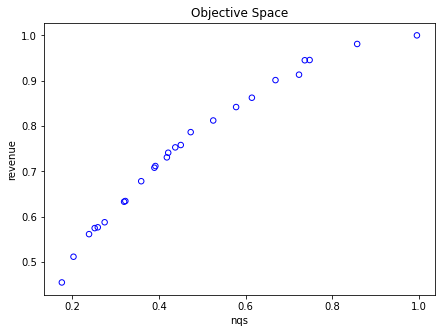

In [159]:
optimize_nq_filtering(user_pct=0.01, population_size=100, n_offsprings=40, term_gens=20, n_partitions=12, n_threads=12, random_seed=0, save=True, verbose=True)

In [2]:
data = generate_data(path='./data/partner_users_dataset.csv', user_pct=0.01)

(34580407, 8)
(34580407, 8)
(33165691, 8)


100%|██████████| 4434/4434 [00:00<00:00, 20706.18it/s]


In [11]:
simulate_filtering(data, x=[26.437167465651434, 20.87477687489137, 13.9190669464003, 41.30969749020242, 14.885932066024598], verbose=True, filter_nqs=True)

  0%|          | 0/4434 [00:00<?, ?it/s]

block_time: 1609991082
block_time: 1611801611
block_time: 1613871964
block_time: 1615687762
block_time: 1617587721
block_time: 1619398599
block_time: 1621311174
block_time: 1623122180
block_time: 1625097571
block_time: 1626913614
block_time: 1629165705
block_time: 1631157007
block_time: 1634520270
block_time: 1636520210
total revenue: $76393.83
total completes: 55442
total clicks: 253963
epc: 0.22
total nqs: 50284
nq rate: 19.8%
{4: {3: 1508, 36: 96, 23: 258, 230: 78, 40: 20, 138: 55, 24: 35, 0: 31, 133: 1, 42: 4, 30: 11, 41: 4, 21: 3, 126: 1}}
{1808718: 2105}


(0.9383, 0.2183, 0.8048)

In [163]:
simulate_filtering(data, x=[26.437167465651434, 20.87477687489137, 13.9190669464003, 41.30969749020242, 14.885932066024598], verbose=True, filter_nqs=False)

total revenue: $89826.8
total completes: 66315
total clicks: 350322
epc: 0.19
total nqs: 80644
nq rate: 23.02%


(1.0, 0.1893, 1.0)

In [166]:
(46000)*0.32

14720.0

In [167]:
89826.8-84894.79

4932.010000000009